## Analyze whether SNWD varies more from year to year or from place to place.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [117]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBBS'
meas='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
2871
+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|          coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-245.32630648756458|-171.75420011844838|264.2151279525999|    451.7|SBBBBBBS| 46.6611| -98.2267|       PRCP|0.9192716524091101|0.8797028820075509|0.7860646548914254|0.8920771623828567|USC00325230

In [118]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [119]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_1'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_1 FROM weather


,station,year,coeff_1
0,USC00325230,1970.0,-245.326306
1,USC00321766,1953.0,-232.029281
2,USC00214106,1949.0,463.786908
3,USW00014919,1953.0,-368.295487
4,USC00322695,1962.0,117.751458


In [120]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_1')
year_station_table.head(10)

station,US1MNCY0001,US1MNCY0003,US1MNNR0001,US1MNPK0002,US1MNWD0980,US1NDCS0001,US1NDCS0004,US1NDCS0009,US1NDCS0015,US1NDCS0023,...,USC00326565,USC00326743,USC00327117,USC00327270,USC00327986,USC00328937,USC00329185,USW00014914,USW00014919,USW00094967
year,,,,,,,,,,,,,,,,,,,,,
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1892.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-110.689482
1894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-74.790729,NaN,NaN,NaN,NaN,NaN,-10.309676
1895.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,154.197916,NaN,NaN,NaN,NaN,NaN,36.396761
1896.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-106.083074,NaN,NaN,NaN,NaN,NaN,NaN
1897.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.111880,NaN,-8.487736,NaN,NaN,NaN,138.617210
1898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-115.440618,NaN,NaN,NaN,40.206362


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the first eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [121]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

def MS(Mat):
    return np.nanmean(Mat**2)

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

val = MS(year_station_table)
val1 = MS(tbl_minus_station)
val2 = MS(tbl_minus_year)
print val, val1, val2
print 'Fraction explained=', (val - MS(tbl_minus_station)) / val
print 'Fraction explained=', (val - MS(tbl_minus_year)) / val

total RMS                   =  121.899211799
RMS removing mean-by-station=  120.23580273
RMS removing mean-by-year   =  58.997872438
14859.4178373 14456.6482582 3480.74895221
Fraction explained= 0.0271053404268
Fraction explained= 0.765754689024


In [15]:
T=year_station_table
print 'initial RMS=',RMS(T)
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)

initial RMS= 631.957294164
0 after removing mean by year    = 329.960575426
0 after removing mean by stations= 310.920358488
1 after removing mean by year    = 309.659157759
1 after removing mean by stations= 309.523374797
2 after removing mean by year    = 309.504389197
2 after removing mean by stations= 309.499416665
3 after removing mean by year    = 309.496335626
3 after removing mean by stations= 309.493603558
4 after removing mean by year    = 309.491011026
4 after removing mean by stations= 309.488525441


In [10]:
sc.stop()

In [18]:
values = year_station_table.head(1)

In [62]:
ar = np.array(year_station_table)
arrT = []
maxArr = 0
for j in range(98):
    arr = []
    for i in ar[j]:
        if np.isnan(i):
            continue
        arr.append(i)
    maxArr = max(maxArr, len(arr))
    arrT.append(arr)
print len(year_station_table), len(arrT), maxArr
for j, i in enumerate(arrT):
    if len(i) == maxArr:
        print j

98 98 36
56


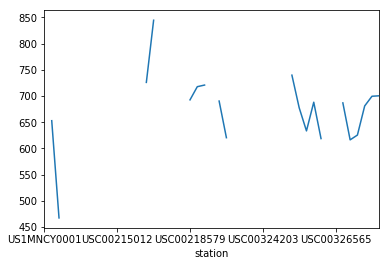

In [94]:
%matplotlib inline
year_station_table.loc[1962].plot.line()

In [95]:
%matplotlib inline
pdf.plot.bar('USC00218579')

KeyError: 'USC00218579'

In [78]:
ar = np.array(year_station_table).T
arrT = []
maxArr = 0
print len(ar)
for j in range(47):
    arr = []
    for i in ar[j]:
        if np.isnan(i):
            continue
        arr.append(i)
    maxArr = max(maxArr, len(arr))
    arrT.append(arr)
print len(year_station_table), len(arrT), maxArr
for j, i in enumerate(arrT):
    if len(i) == maxArr:
        print j

47
98 47 55
20


In [87]:
year_station_table.loc[str(USC00218579]

AttributeError: 'DataFrame' object has no attribute 'station'